# The Audio-Video Overlay

The audio video overlay contains a HDMI video capture controller, a VGA video display controller, an audio controller that connects to the Headphone (HPH) and the Line In ports on the board, and 2 IOPs.

<img src="_images/zyboaudiovideo.jpeg" width="400">

The two IOPs, represented in the image as Port 1 and Port 2 are the same as in the PMODIO Overlay. Please refer to the PMODIO OVERLAY for more information about the IOP. 

## Video IO
The overlay contains two video controllers, video input (HDMI), and video output (VGA). Both can be independently controlled, or used in combination to capture an image on the HDMI and display it on the VGA.

## The HDMI video capture controller
To use the HDMI in controller, connect the on-board HDMI port to a valid video source. E.g. your laptop can be used if it has HDMI out. Any HDMI video source can be used up to 1080p.

To use the HDMI in, ensure you have connected a valid HDMI source and execute the next cell. If a valid HDMI source is not detected, the kernel will hang and restart.

In [1]:
from pynq.video import HDMI
from pynq import Overlay
ol = Overlay("audiovideo.bit")
ol.download()
hdmi = HDMI('in')

The HDMI() argument ‘in’ indicates that the object is in capture mode. Currently, this is the only supported mode for HDMI.

When a valid video input source is connected, the controller should recognize it and start automatically. 

## Starting and stopping the controller

You can manually start/stop the controller

In [2]:
hdmi.stop()

In [3]:
import time
time.sleep(2) # add delay to allow time for HDMI to initialize before starting below (This allows whole workbook to be executed)

In [4]:
hdmi.start()

If you see an error message: SystemError: Unable to start capture device [13]

Wait a few seconds and rerun the hdmi.start() cell

## Readback from the controller
To check the state of the controller:

In [5]:
state = hdmi.state()
print(state)

1


The state is returned as an integer value, with one of 3 possible values:

* 0 if disconnected
* 1 if streaming
* 2 if paused

You can also check the width and height of the input source (assuming a source is connected):

In [6]:
width = hdmi.frame_width()
height = hdmi.frame_height()
print('HDMI is capturing a video source of resolution {}x{}'.format(width,height))

HDMI is capturing a video source of resolution 1920x1080


## HDMI Frame buffer
The HDMI object holds a frame buffer, that can contain up to 3 frames, and is where the controller stores the captured frames. At the object instantiation, the current frame is the one at index 0. You can check at any time which frame index is active:

In [7]:
hdmi.frame_index()

0

The frame_index() method can also be used to set a new index, if you specify an argument with the method call. For instance:

In [8]:
index = hdmi.frame_index()
hdmi.frame_index(index + 1)

This will set the current frame index to the next in the sequence. However, if the index is 2 (the last frame in buffer), index+1 will cause an exception. 
If you want to set the next frame in the sequence, use:

In [9]:
hdmi.frame_index_next()

2

This will loop through the frame buffer and it will also return the new index as an integer.

### Access the current frame
There are two ways to access pixel data; _hdmi.frame()_ and _hdmi.frame_raw()_

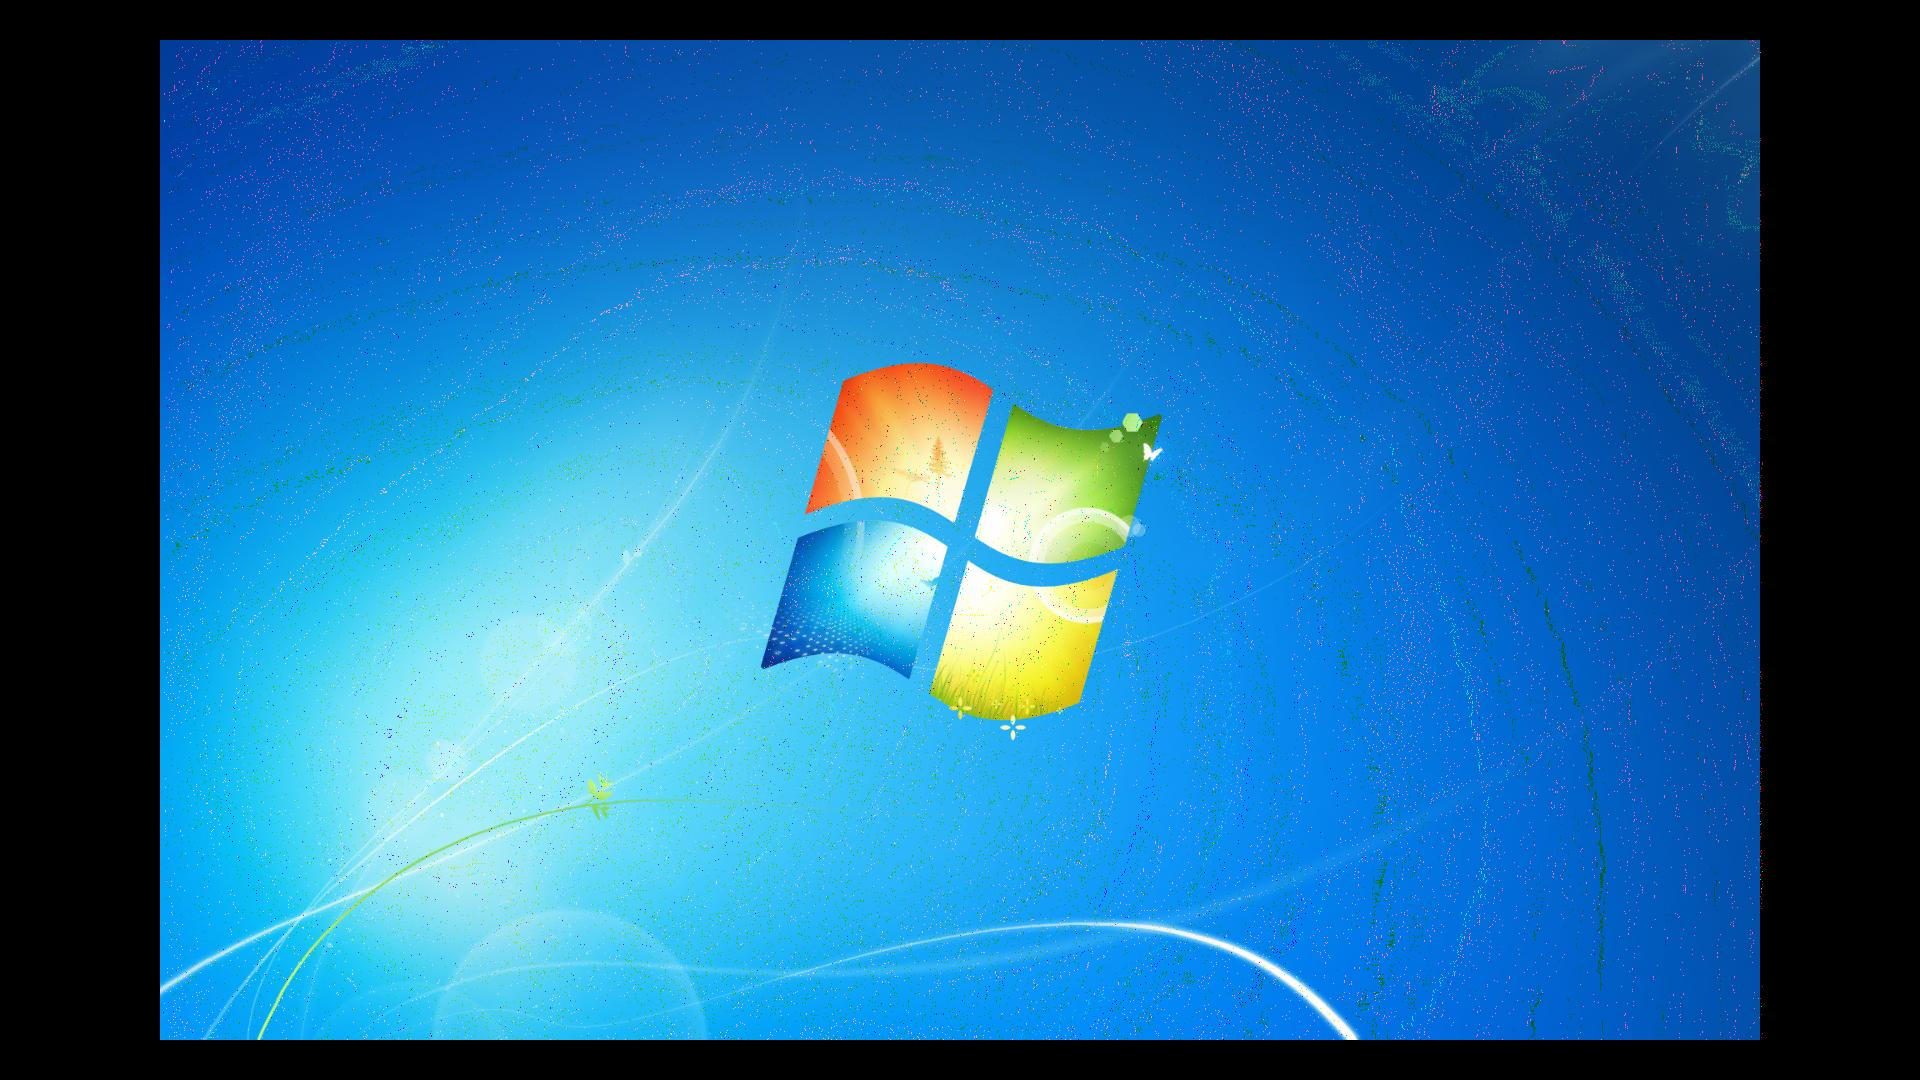

In [10]:
from IPython.display import Image
frame = hdmi.frame()
frame.save_as_jpeg('audio_video.jpg')
Image(filename='audio_video.jpg')

This will dump the frame as a python list _frame[height, width][rgb]_. Where rgb is a tuple (r,g,b). If you want to modify the green component of a pixel, you can do it as shown below. In the example, the top left quarter of the image will have the green component increased. 

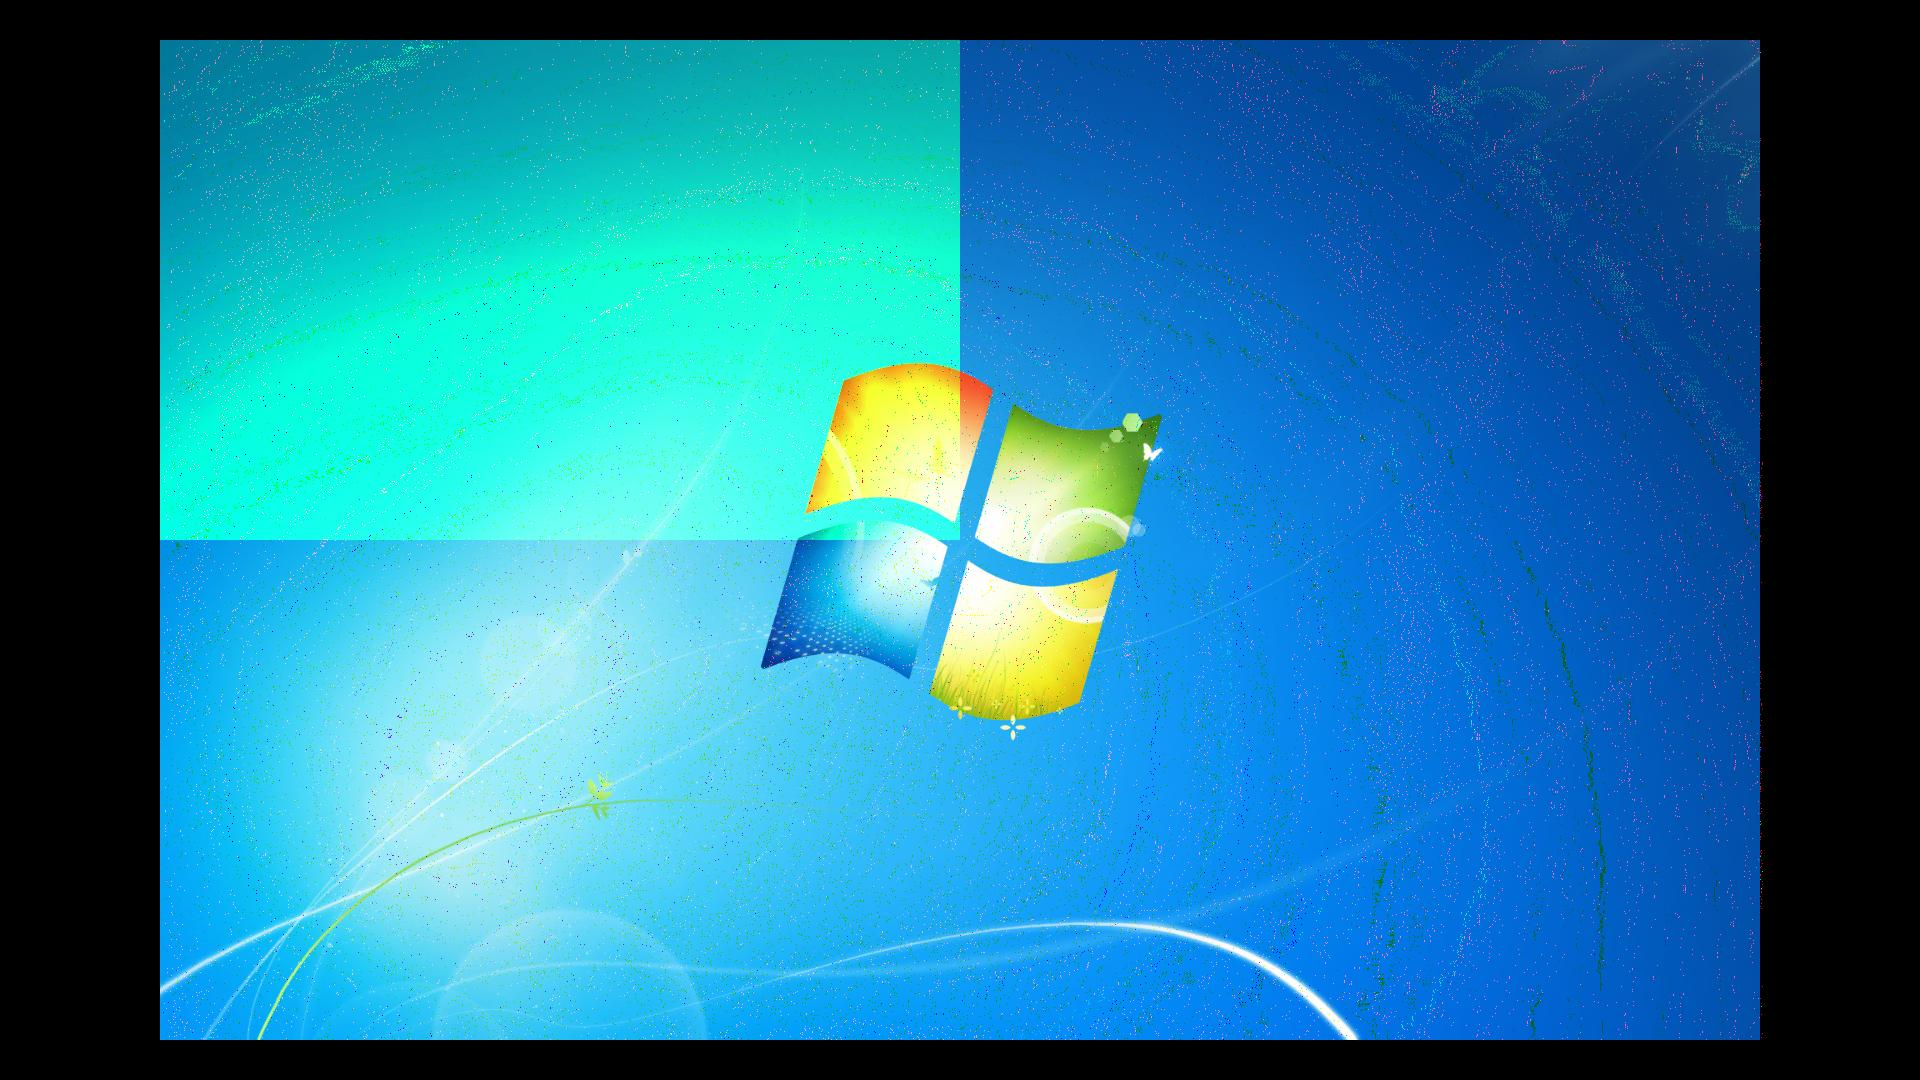

In [11]:
for x in range(int(width/2)):
    for y in range(int(height/2)):
        (red,green,blue) = frame[x,y]
        green = green*2
        if(green>255):
            green = 255
        frame[x,y] = (red, green, blue)

frame.save_as_jpeg('audio_video1.jpg')
Image(filename='audio_video1.jpg')

This frame() method is a simple way to capture pixel data, but may be slow. If you want to dump a frame at a specific index, just pass the index as an argument of the frame() method:

In [12]:
frame = hdmi.frame(2) # dumping frame at index 2

If higher performance is required, the frame_raw() method can be used:

In [13]:
frame_raw = hdmi.frame_raw() # dumping frame at current index
frame_raw = hdmi.frame_raw(2) # dumping frame at index 2

This method will return a fast memory dump of the internal frame buffer, as a mono-dimensional list of dimension frame[1920*1080*3] (This array is of fixed size regardless of the input source resolution). 1920x1080 is the maximum supported frame dimension and 3 separate values for each pixel (Blue, Green, Red). 

When the  resolution is less than 1920x1080, the user must manually extract the correct pixel data. 

E.g. if the resolution of the video input source is 800x600:

In this example, meaningful values will only be in the range frame_raw[1920*i*3] to frame_raw[(1920*i + 799)*3] for each i (rows) from 0 to 599. Any other position outside of this range will contain invalid data.

In [14]:
print(frame_raw[1]) # printing the green component of pixel (0,0)
print(frame_raw[1920 + 399 + 0]) # printing the blue component of pixel (1,399)
print(frame_raw[1920*599 + 799 + 2]) # printing the red component of the last pixel (599,799)

0
0
70


## The VGA video display controller

Using the VGA controller is  similar to using the HDMI. Connect the on-board VGA port to a monitor, or other VGA display device. 

To instantiate the VGA controller:

In [15]:
from pynq.video import VGA
vga = VGA('out')

For the VGA controller, you have to start/stop the device explicitly:

In [16]:
vga.stop()

In [17]:
vga.start()

To check the state of the controller:

In [18]:
state = vga.state()
print(state)

1


The state is returned as an integer value, with 2 possible values:

* 0 if stopped
* 1 if running

After initialization, the display resolution is set at the lowest level: 640x490@60Hz. 

To check the current resolution:

In [19]:
print(vga.mode())

640x480@60Hz


This will print the current mode as a string. To change the mode, insert a valid index as an argument when calling mode():

In [20]:
vga.mode(2) # 1280x720@60Hz

'1280x720@60Hz'

Valid resolutions are:

* 0 : '640x480@60Hz
* 1 : '800x600@60Hz
* 2 : '1280x720@60Hz
* 3 : '1280x1024@60Hz
* 4 : '1920x1080@60Hz

Similar to HDMI, you can access the current resolution width and height:

In [21]:
width = vga.frame_width()
height = vga.frame_height()
print('VGA resolution is {}x{}'.format(width,height))

VGA resolution is 1280x720


and access the current frame, or change it using the same methods:

In [22]:
index = vga.frame_index()
vga.frame_index(2)
vga.frame_index_next()

0

Again, similar to the HDMI controller, frame() can be used to dump the current frame content, or the frame at a specific index using frame(index). The faster frame_raw() is also available. 

To send a new frame to the VGA and display it, pass the new _frame[height][width][rgb]_ as an argument to _frame()_ or your new _frame_raw[1920*1080*3]_ to _frame_raw()_. This will copy your new frame content to the VGA’s frame buffer.

In [23]:
vga.frame(frame) # copying new frame at current index

In [24]:
vga.frame(2, frame) # copying new frame at index 2

In [25]:
vga.frame_raw(frame_raw) # copying new frame_raw at current index

In [26]:
vga.frame_raw(1, frame_raw) # copying new frame_raw at index 1

### Smooth Display
To draw or display smooth animations/video, note the following:

When you want to draw a new frame, copy it to a frame location not currently used (an index different from the one at vga.frame_index()) . Once the copy is done, change the current frame index to point to the index where you copied the new frame you want to display.

### Using HDMI and VGA in combination
To use the HDMI and VGA to capture and display an image, make both the HDMI and VGA share the same frame buffer. The frame buffer in both cases can be accessed using the frame_buffer() method. You can make the two object share the same frame buffer passing the first declared object's frame buffer as an argument of the second object’s constructor:

In [27]:
hdmi = HDMI('in')
vga = VGA('out', hdmi.frame_buffer)

or equivalently:

In [28]:
vga = VGA('out')
hdmi = HDMI('in', vga.frame_buffer)

Once this is done, start() the VGA object and if you should see the input HDMI on the VGA output. Remember, both the object must have the same active frame_index. 
Initially, both frame indexes start from 0.

You can use the two objects for most interesting applications. For example, a frame captured from HDMI can be processed using python and displayed on the VGA. 
For an example of a sobel filter (edge detection), see [demo_hdmi_vga](audiovideo_sobel). 

## Using Audio IO
The overlay contains an audio controller that allows you to control both the HPH output port and the Line In input port of the Zybo. To instantiate the two objects:

In [29]:
from pynq.audio import LineIn
from pynq.audio import Headphone
headphone = Headphone()
linein = LineIn()

Connect the Line In port to an audio source using a standard 3mm cable. Connect earphones/speakers to the HPH. To do a simple passthrough from input (Line In) to output (HPH) read the input, and write the value to the output

In [30]:
audio_sample = linein()
print('left channel: {}'.format(audio_sample[0]))
print('right channel: {}'.format(audio_sample[1]))

left channel: 12391825
right channel: 12393967


The content of _audio_sample_ will be a tuple representing the read values from the left and right channels [left, right]. The _Headphone_ expects data of the same type. You can either pass the input directly to the output, carry out some processing on the data, or write your own samples to hph():

In [31]:
import time
time_end = time.time() + 15 # set end time to current time + 15 seconds
while time.time() < time_end:
    audio_sample = linein()
    headphone(audio_sample)
print("Done") 

Done


This example alternates between setting the left channel and the right channel to 0 approximately every 2 seconds

In [32]:
from pynq.audio import LineIn
from pynq.audio import Headphone
headphone = Headphone()
linein = LineIn()
import time
time_end = time.time() + 15 # set end time to current time + 15 seconds
while time.time() < time_end:
    (left,right) = linein()
    x = int(time.time() %4)
    if(x >=2):
        right = 0
    else:
        left = 0
    headphone([left, right])
print("Done") 

Done
